In [1]:
import sys
sys.path.insert(0,'c:/MyDocs/integrated/') # adjust to your setup

%run "catalog_support.py" 
showHeader('FracFocus<br>Big Picture Stats',use_remote=False)

<IPython.core.display.Javascript object>

Open-FF,"FracFocusBig Picture Stats This file was generated on February 01, 2024 from data repository: openFF_data_2024_01_18.",Sponsored by FracTracker Alliance


In [2]:
# fetch data set
master_df = fh.get_df(os.path.join(hndl.curr_repo_dir,'full_df.parquet'))
master_df = master_df[(master_df.date.dt.year>2010)&\
                      (master_df.date.dt.year<=datetime.datetime.now().year)]

   
## Contents:
**[General Statistics](#gen_stats)**
Number of disclosures per week, geographic spread

**[Chemicals used](#chems)** (in development)

**[Water Use](#water_use)**
Weekly: Median, Total and Max water used

**[Proppant Use](#proppant)**
Weekly: Sand, other proppants

**[Companies represented](#companies)** (in development)

**[Downloadable Data Sets](#data)**
water and sand use, by disclosure

---
<a id='gen_stats'></a>
# General Stats

The figures below use filtered data (no duplicate disclosures or records) for Jan 1, 2011 to the most recently published data.  Because of publishing delays, the most recent months are probably under represented.

**In the early data, roughly 2011 - May 2013, the bulk download does not include chemical records.**  However, the PDF files for that period are still served through ["Find_A-Well"](https://fracfocus.org/wells/advanced) and document the reported chemicals.  Some projects have attempted to scrape those chemical records into an organized data set but they come with caveats (such as they may contain records that the industry no longer considers valid; or they are incomplete because many of the PDFs are poorly formatted and therefore difficult to scrape). 

<a id='num_disc'></a>

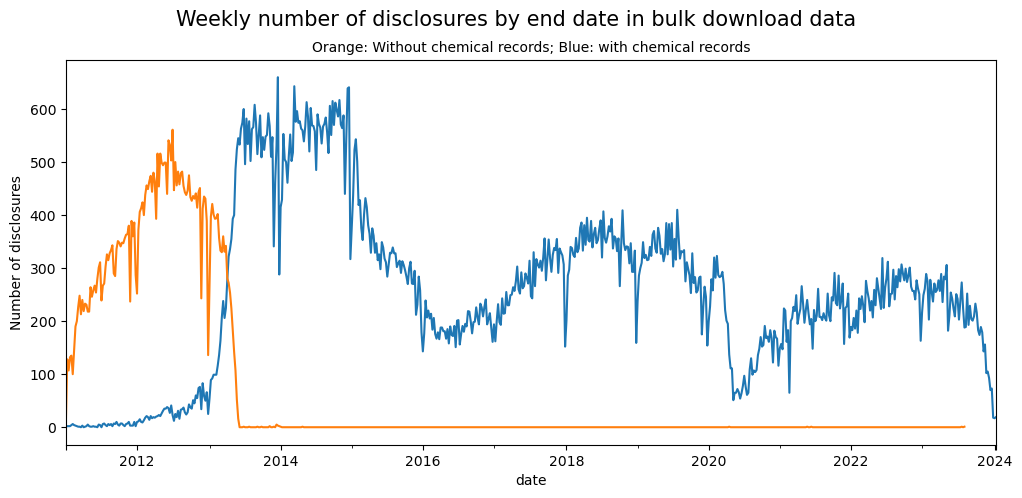

In [3]:
gb = master_df.groupby('DisclosureId',as_index=False)['date'].first()
gb1 = master_df.groupby('DisclosureId',as_index=False)['ingKeyPresent'].sum()
mg = pd.merge(gb,gb1,on='DisclosureId',how='left')
gb2 = mg[mg.ingKeyPresent>0].groupby('date').size()
allwk_sum = gb2.resample("W").sum()
ax = allwk_sum.plot(figsize=(12,5), ylabel='Number of disclosures');
ax.set_title('Orange: Without chemical records; Blue: with chemical records',fontsize=10);
plt.suptitle('Weekly number of disclosures by end date in bulk download data',fontsize=15);

gb3 = mg[mg.ingKeyPresent==0].groupby('date').size()
# alldfv1 = master_df[~master_df.ingKeyPresent].groupby('DisclosureId',as_index=False)[['date','TotalBaseWaterVolume']].first()
# gbv1 = gb3.groupby('date').size()
allwk_sumv1 = gb3.resample("W").sum()
allwk_sumv1.plot(ax=ax);



## Where are they?
For more detailed maps of each state, see the ["States and Counties"](Open-FF_States_and_Counties.html) pages.

In [4]:

gb = master_df[master_df.loc_within_state=='YES'].groupby(['bgStateName',
                                                           'DisclosureId'],as_index=False)['bgCAS'].count()
gb = gb.groupby('bgStateName',as_index=False)['DisclosureId'].count().rename({'bgStateName':'StateName',
                                                                           'DisclosureId':'value'},
                                                                          axis=1)
# gb = pd.read_csv(r"C:\MyDocs\OpenFF\src\testing\tmp\temp.csv")
mapping.create_state_choropleth(gb,plotlog=True,custom_scale= [0,1,2,3,4,5,6],
                        legend_name='Number of FracFocus disclosures',
                        start_zoom=3,fields=['StateName','orig_value'],
                        aliases = ['State: ','Number of FF disclosures: ']
                       )


---
<a id='chems'></a>
# Chemicals used
- in development

---
<a id='water_use'></a>
# Water use

## Gallons used, recorded as TotalBaseWaterVolume

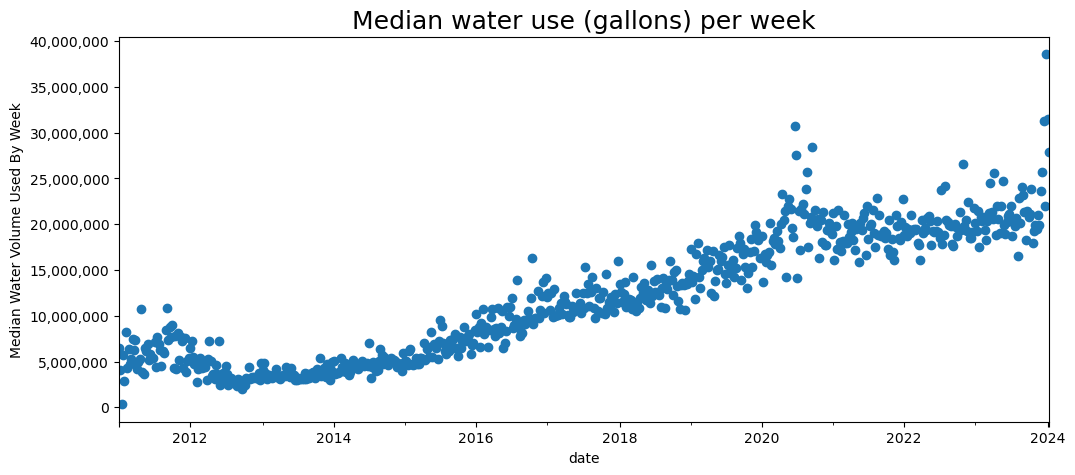

In [5]:
alldf = master_df.groupby('DisclosureId',as_index=False)[['date','TotalBaseWaterVolume','APINumber','bgStateName']].first()
gb1 = alldf.groupby('date')['TotalBaseWaterVolume'].median()
allwk_tbwv = gb1.resample("W").max()
ax = allwk_tbwv.plot(figsize=(12,5), ylabel='Median Water Volume Used By Week',style='o');
ax.set_title('Median water use (gallons) per week',fontsize=18);
ax = gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


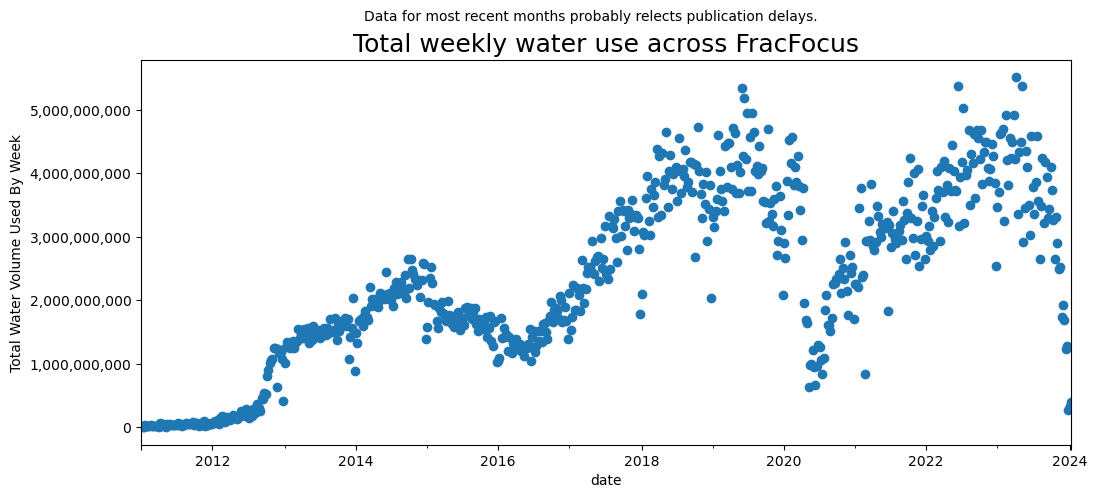

In [6]:
gb3 = alldf.groupby('date')['TotalBaseWaterVolume'].sum()
allwk_tbwv_sum = gb3.resample("W").sum()
ax = allwk_tbwv_sum.plot(figsize=(12,5), ylabel='Total Water Volume Used By Week',style='o');
ax.set_title('Total weekly water use across FracFocus',fontsize=18);
plt.suptitle('Data for most recent months probably relects publication delays.',fontsize=10);
ax = gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))



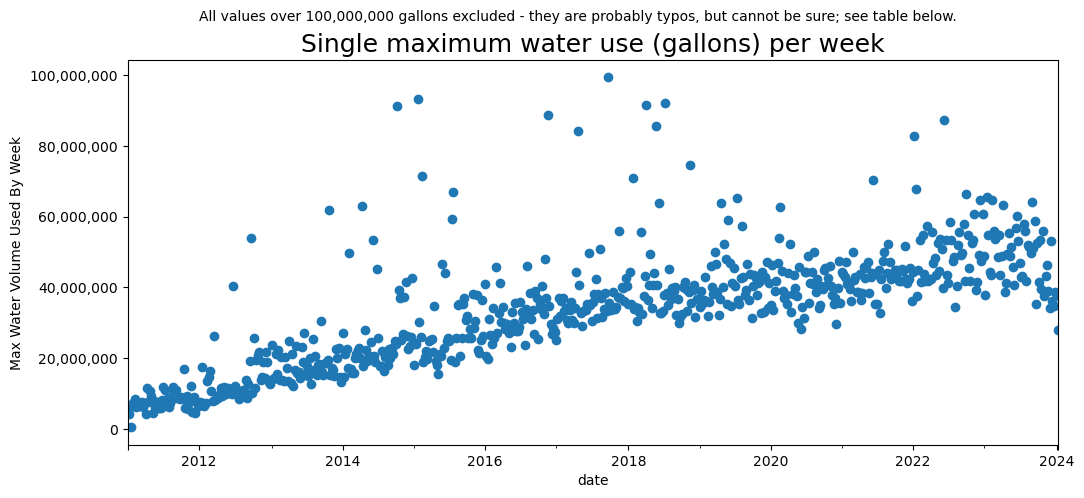

In [7]:
gb1 = alldf.groupby('date')['TotalBaseWaterVolume'].max()

gb2 = gb1[gb1<100000000]
allwk_tbwv = gb2.resample("W").max()
ax = allwk_tbwv.plot(figsize=(12,5), ylabel='Max Water Volume Used By Week',style='o');
ax.set_title('Single maximum water use (gallons) per week',fontsize=18);
plt.suptitle('All values over 100,000,000 gallons excluded - they are probably typos, but cannot be sure; see table below.',fontsize=10);
ax = gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


In [8]:
print('Disclosures over 100 million gallons')
summary = alldf[alldf.TotalBaseWaterVolume>100000000].groupby('date')[['TotalBaseWaterVolume','APINumber','bgStateName']].first()
summary.TotalBaseWaterVolume = summary.TotalBaseWaterVolume.map(lambda x: th.round_sig(x,5))
print(summary.sort_values('date'))

Disclosures over 100 million gallons
           TotalBaseWaterVolume       APINumber   bgStateName
date                                                         
2016-01-12          156,040,000  42483339170000         texas
2016-09-20          143,650,000  42227387470000         texas
2016-12-30          472,440,000  42389353070000         texas
2017-02-28          136,740,000  42389351890000         texas
2019-06-15          349,700,000  42317419420000         texas
2019-10-09          201,440,000  42371399350000         texas
2020-04-06          139,680,000  37117220600000  pennsylvania
2021-01-29          185,080,000  42317432090000         texas
2022-03-30          346,790,000  17031270600000     louisiana
2022-04-01          109,160,000  49035278320000       wyoming
2022-05-31          293,210,000  42227413230000         texas
2022-10-18          211,590,000  35063249470000      oklahoma
2022-11-26          110,900,000  33013019050000  north dakota
2023-03-06          103,180,000  

---
<a id='proppant'></a>
# Proppants
Most 2011- mid 2013 disclosures do not have chemical records.  Proppants are, therefore, missing in those years in the figures below.

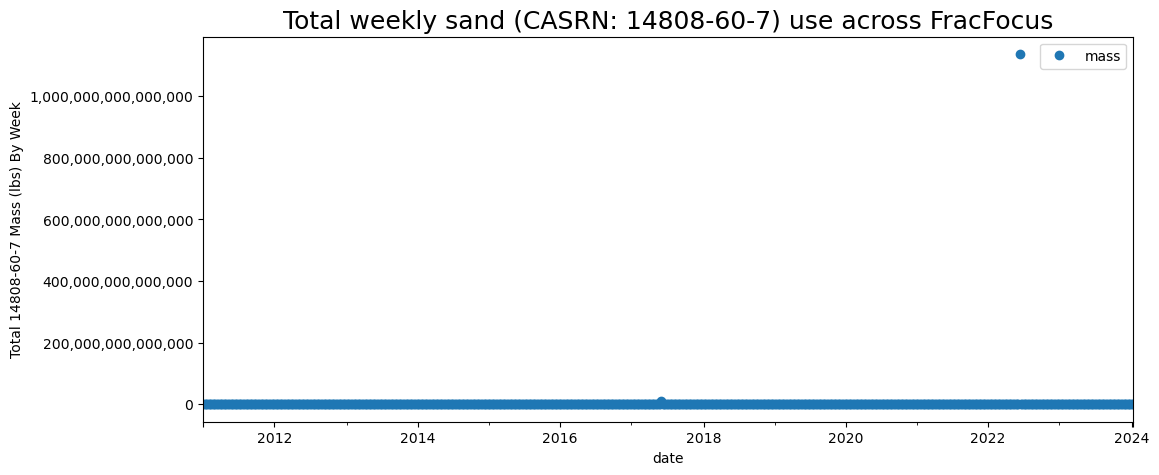

In [9]:
# gb1 = master_df.groupby('DisclosureId',as_index=False)[['APINumber','date','TotalBaseWaterVolume','bgStateName']].first()
gb3 = master_df[master_df.bgCAS=='14808-60-7'].groupby('date')[['mass']].sum()
allwk_sand_sum = gb3.resample("W").sum()
otherprop = ['66402-68-4','1302-93-8','1302-76-7','1344-28-1','1318-16-7','308075-07-2','14464-46-1','1302-74-5']

ax = allwk_sand_sum.plot(figsize=(12,5), ylabel='Total 14808-60-7 Mass (lbs) By Week',style='o');
ax.set_title('Total weekly sand (CASRN: 14808-60-7) use across FracFocus',fontsize=18)
ax = gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));


List of "other proppants" graphed: 
         bgCAS                           epa_pref_name
0    1302-74-5               Corundum (Aluminum oxide)
1    1302-76-7                    Kyanite (Al2O(SiO4))
2    1302-93-8                  Mullite (Al6O5(SiO4)2)
3    1318-16-7                                 Bauxite
4    1344-28-1                                 Alumina
5   14464-46-1                            Cristobalite
6  308075-07-2                                    Sand
7   66402-68-4  Ceramic materials and wares, chemicals



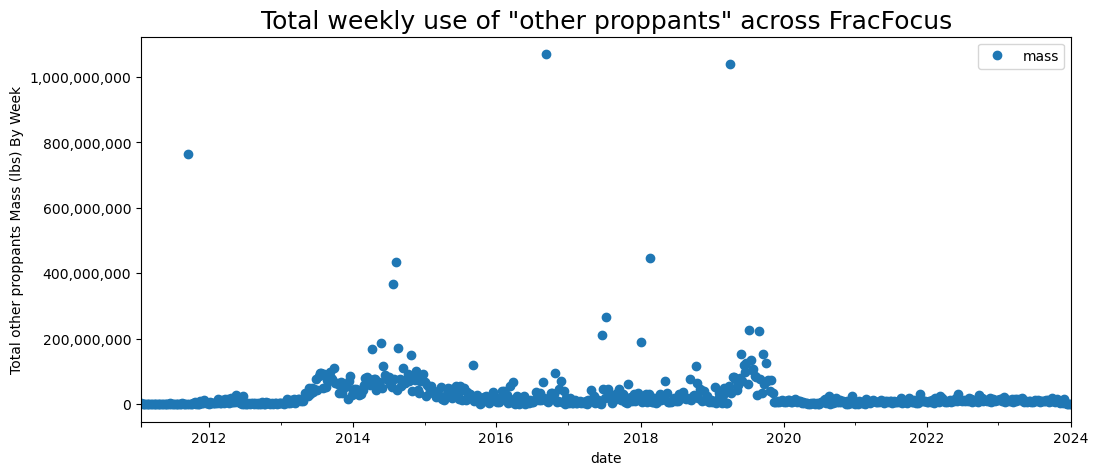

In [10]:
gb3 = master_df[master_df.bgCAS.isin(otherprop)].groupby('date')[['mass']].sum()
allwk_other_sum = gb3.resample("W").sum()
ax = allwk_other_sum.plot(figsize=(12,5), ylabel='Total other proppants Mass (lbs) By Week',style='o');
ax.set_title('Total weekly use of "other proppants" across FracFocus',fontsize=18)
ax = gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));

props = master_df[master_df.bgCAS.isin(otherprop)].groupby('bgCAS',as_index=False)['epa_pref_name'].first()
print(f'List of "other proppants" graphed: \n{props}\n')

---
<a id='companies'></a>
# Companies represented

## Operators
Operators are the companies that manage the permits, the wells and submit the disclosures.  There is a single operator for each fracking job.  

There are many Operator companies.  A large fraction of them manage only a handful of fracking jobs/wells.  The dominant operators have thousands of wells. To explore individual Operators, use the [Operator Index](Open-FF_Operator_index.html)

The data field in Open-FF named `bgOperatorName` is a form of the FracFocus field `OperatorName` that allows for more comprehensive searches.

In [11]:
ogb = master_df.groupby(['bgOperatorName','DisclosureId'],as_index=False).size()
ogbname = master_df.groupby(['bgOperatorName'])['OperatorName'].agg(lambda x: x.value_counts().index[0])
ogbname = ogbname.reset_index()
mg = pd.merge(ogb,ogbname,on='bgOperatorName',how='left')
# ogb = ogb.groupby('bgOperatorName',as_index=False).size()
# ogb = ogb.sort_values('size',ascending=False)
# ogb.plot.barh('size','bgOperatorName')
h = mg.OperatorName.value_counts()
print(f'Total number bgOperatorName: {len(h)},\n number with fewer than 20 disclosures: {len(h[h<20])},\n with fewer than 5: {len(h[h<5])}')

Total number bgOperatorName: 1586,
 number with fewer than 20 disclosures: 1009,
 with fewer than 5: 613


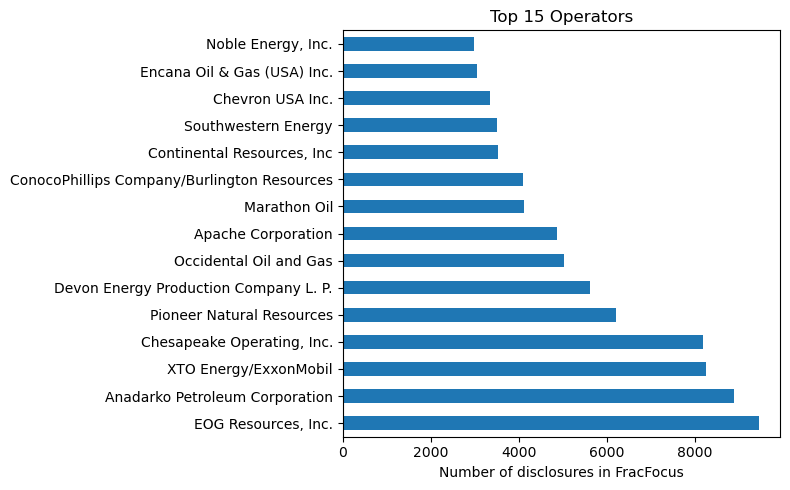

In [12]:
ax = mg.OperatorName.value_counts()[:15].plot.barh(figsize=(8,5))
ax.set_title('Top 15 Operators')
ax.set_xlabel('Number of disclosures in FracFocus');
plt.tight_layout();
# plt.savefig(os.path.join(image_dir,'operators.jpg'),dpi=150)

## Suppliers

Suppliers are companies that may supply the products used in a fracking job, they may be the oilfield service company or even a transport company.  Because a supplier is associated with single records within a disclosure, there are often multiple companies named as suppliers on a single dislcosure.   

The data field in Open-FF named `bgSupplier` is a form of the FracFocus field `Supplier` that aggregates variations in spellings and typos to allow for more comprehensive searching.

Total number bgSupplier: 1619,
 number with fewer than 20 disclosures: 931,
 with fewer than 5: 557


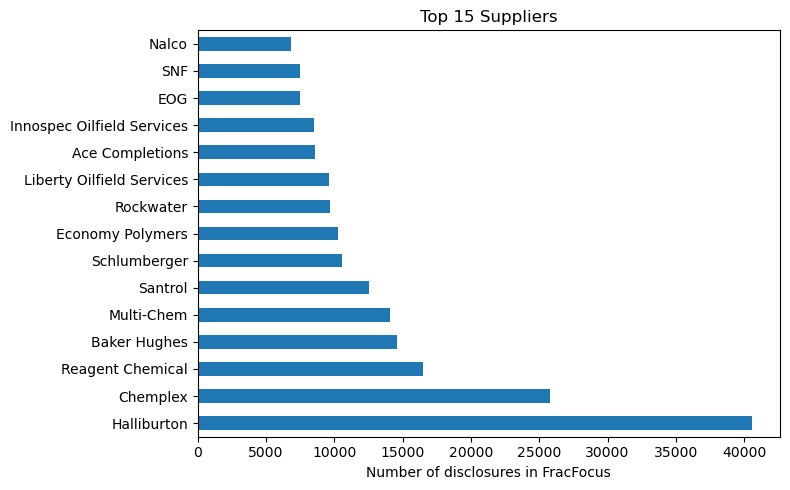

In [13]:
sgb = master_df.groupby(['bgSupplier','DisclosureId'],as_index=False).size()
sgbname = master_df.groupby(['bgSupplier'])['Supplier'].agg(lambda x: x.value_counts().index[0])
sgbname = sgbname.reset_index()
mg = pd.merge(sgb,sgbname,on='bgSupplier',how='left')

x = ['MISSING','Listed Above','Operator','Customer','Ingredient Container']
mg = mg[~mg.Supplier.isin(x)]
h = mg.Supplier.value_counts()
print(f'Total number bgSupplier: {len(h)},\n number with fewer than 20 disclosures: {len(h[h<20])},\n with fewer than 5: {len(h[h<5])}')

ax = mg.Supplier.value_counts()[:15].plot.barh(figsize=(8,5))
ax.set_xlabel('Number of disclosures in FracFocus');
ax.set_title('Top 15 Suppliers');
plt.tight_layout();
# plt.savefig(os.path.join(image_dir,'suppliers.jpg'),dpi=150)

---
<a id='data'></a>
# Summary Data
Data sets that offer quick access to the Open-FF data for commonly requested fields.  (If you have data you would like to access regularly, let us know and we can add a link to this section.)

| Data Set with link | Description |
| :--: | :-- |
| [Water, Sand and BTEX use](scope/water_sand_btex.zip)|- all locations from 2011 to last major update in FracFocus<br>- Total base **water volume** (in gallons)<br><br> *Masses below are in pounds and are for disclosures for which mass is calculable.*<br>- **sand** (CASRN: 14808-60-7) mass<br>- **benzene** (CASRN: 71-43-2) mass<br>- **toluene** (CASRN: 108-88-3) mass<br>- **ethylbenzene** (CASRN: 100-41-4) mass<br>- **xylene**(CASRN: 1330-20-7) mass<br> - "OperatorName" is field as given in FracFocus.<br>- "bgOperatorName" is a generated field to standardize multiple names for the same company.<br>- "APINumber" is a 14-digit number (as text string) from the FracFocus; early disclosures with only 10-digits are filled out with 'XXXX'<br>- "api10" is a simple 10-digit version of the APINumber (as a text string)|
